![](https://miro.medium.com/max/809/0*tamvSiqDneDfw2Vr)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
data = pd.read_csv('https://drive.google.com/uc?id=1T4ak0Nyvt-mrpZPCgAo0aVq4b6LrfCA1')
data.head(1)

,Unnamed: 0,StartDate,EndDate,q0001,q0002,q0004_0001,q0004_0002,q0004_0003,q0004_0004,q0004_0005,q0004_0006,q0005,q0007_0001,q0007_0002,q0007_0003,q0007_0004,q0007_0005,q0007_0006,q0007_0007,q0007_0008,q0007_0009,q0007_0010,q0007_0011,q0008_0001,q0008_0002,q0008_0003,q0008_0004,q0008_0005,q0008_0006,q0008_0007,q0008_0008,q0008_0009,q0008_0010,q0008_0011,q0008_0012,q0009,q0010_0001,q0010_0002,q0010_0003,q0010_0004,q0010_0005,q0010_0006,q0010_0007,q0010_0008,q0011_0001,q0011_0002,q0011_0003,q0011_0004,q0011_0005,q0012_0001,q0012_0002,q0012_0003,q0012_0004,q0012_0005,q0012_0006,q0012_0007,q0013,q0014,q0015,q0017,q0018,q0019_0001,q0019_0002,q0019_0003,q0019_0004,q0019_0005,q0019_0006,q0019_0007,q0020_0001,q0020_0002,q0020_0003,q0020_0004,q0020_0005,q0020_0006,q0021_0001,q0021_0002,q0021_0003,q0021_0004,q0022,q0024,q0025_0001,q0025_0002,q0025_0003,q0026,q0028,q0029,q0030,q0034,q0035,q0036,race2,racethn4,educ3,educ4,age3,kids,orientation,weight
0,1,5/10/18 4:01,5/10/18 4:06,Somewhat masculine,Somewhat important,Not selected,Not selected,Not selected,Pop culture,Not selected,Not selected,Yes,Often,Often,Often,Often,"Never, and not open to it","Never, and not open to it",Often,Sometimes,Sometimes,"Never, and not open to it",Often,Not selected,Not selected,Your hair or hairline,Not selected,Not selected,Not selected,Not selected,Not selected,Your physical health,"Your finances, including your current or futur...",Not selected,Not selected,"Not employed, NOT looking for work",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Sometimes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Read their physical body language to see if th...,Ask for a verbal confirmation of consent,Make a physical move to see how they react,Every situation is different,It isn?t always clear how to gauge someone?s i...,Not selected,Not selected,Not selected,Not selected,None of the above,No,Never married,Not selected,Not selected,No children,Gay,Hispanic,College graduate,New York,"$0-$9,999",Middle Atlantic,Windows Desktop / Laptop,Non-white,Hispanic,College or more,College or more,35 - 64,No children,Gay/Bisexual,1.714026


## Data Cleaning

In [3]:
data.isnull().sum().sum()

16612

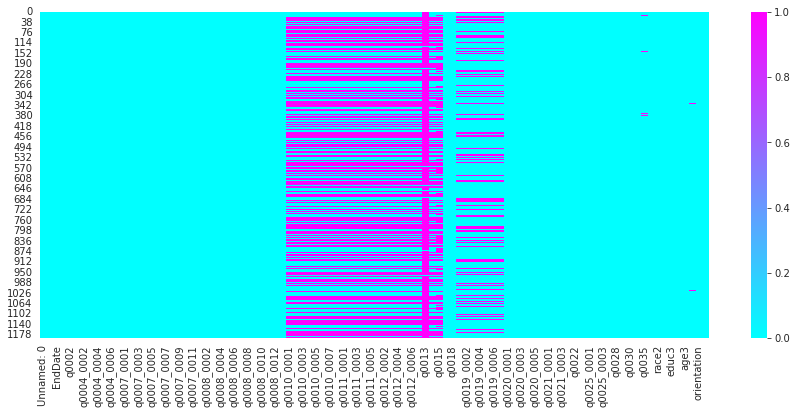

In [4]:
plt.figure(figsize=(15,6))
sns.heatmap(data.isnull(), cmap='cool')
plt.show()

## Removing Null Values

In [5]:
print(f'Initial Null Values - {data.isnull().sum().sum()}')
for i in data.columns:
    if data[i].isnull().sum() > 20:
        data.drop(i, axis=1, inplace=True)
print(f'Final Null Values - {data.isnull().sum().sum()}')

Initial Null Values - 16612
Final Null Values - 27


In [6]:
print(data.shape)
data.dropna(inplace=True)
data.shape

(1189, 68)


(1171, 68)

In [7]:
data.rename(columns = {'Unnamed: 0':'Id', 'q0001':'Masculinity'}, inplace=True)

## Removing Unnecessary Columns 

In [8]:
for i in data.columns:
    if (data[i] == 'Not selected').sum() > 400:
        data.drop(i, axis=1, inplace=True)
data.shape

(1171, 39)

In [9]:
X = data.drop(['Id', 'Masculinity'], axis=1)

## Label Encoding

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
label = LabelEncoder()
for i in X.columns:
    X[i] = label.fit_transform(X[i])
X.head(2)

,StartDate,EndDate,q0002,q0004_0001,q0005,q0007_0001,q0007_0002,q0007_0003,q0007_0004,q0007_0005,q0007_0006,q0007_0007,q0007_0008,q0007_0009,q0007_0010,q0007_0011,q0009,q0017,q0018,q0021_0004,q0022,q0024,q0026,q0028,q0029,q0030,q0034,q0035,q0036,race2,racethn4,educ3,educ4,age3,kids,orientation,weight
0,2,2,3,1,2,3,3,3,3,0,0,3,5,5,0,3,3,2,5,0,0,2,1,2,1,32,0,2,3,0,1,0,0,1,1,0,323
1,3,3,3,0,2,4,5,1,4,0,4,0,3,0,5,2,6,0,4,0,0,5,4,4,5,35,8,0,4,1,3,2,3,2,0,3,294


## Feature Scaling

In [11]:
scaler = MinMaxScaler()
for i in X.columns:
    X[i] = scaler.fit_transform(X[[i]])
X.head(2)

,StartDate,EndDate,q0002,q0004_0001,q0005,q0007_0001,q0007_0002,q0007_0003,q0007_0004,q0007_0005,q0007_0006,q0007_0007,q0007_0008,q0007_0009,q0007_0010,q0007_0011,q0009,q0017,q0018,q0021_0004,q0022,q0024,q0026,q0028,q0029,q0030,q0034,q0035,q0036,race2,racethn4,educ3,educ4,age3,kids,orientation,weight
0,0.001969,0.00198,0.75,1.0,1.0,0.6,0.6,0.6,0.6,0.0,0.0,0.6,1.0,1.0,0.0,0.6,0.5,1.0,1.0,0.0,0.0,0.4,0.25,0.5,0.2,0.64,0.0,0.25,0.75,0.0,0.333333,0.0,0.0,0.5,1.0,0.0,0.737443
1,0.002953,0.00297,0.75,0.0,1.0,0.8,1.0,0.2,0.8,0.0,0.8,0.0,0.6,0.0,1.0,0.4,1.0,0.0,0.8,0.0,0.0,1.0,1.00,1.0,1.0,0.70,0.8,0.00,1.00,1.0,1.000000,1.0,1.0,1.0,0.0,1.0,0.671233


In [12]:
from sklearn.decomposition import PCA
pca = PCA(2)
X = pca.fit_transform(X)

## Selecting correct number of Clusters using Elbow Method

In [13]:
from sklearn.cluster import KMeans

l  = []
for i in range(1,10):
    model = KMeans(n_clusters=i, random_state = 42)
    model.fit(X)
    l.append(model.inertia_)

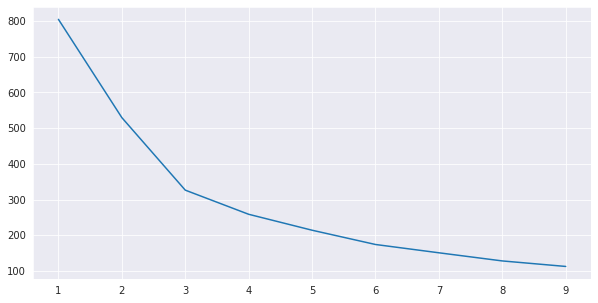

In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 10), l)
plt.show()

### We'll select 3 as the number of clusters

## Model Training

In [15]:
model = KMeans(n_clusters=3, random_state=42)

y = model.fit_predict(X)

## Visualizing Output

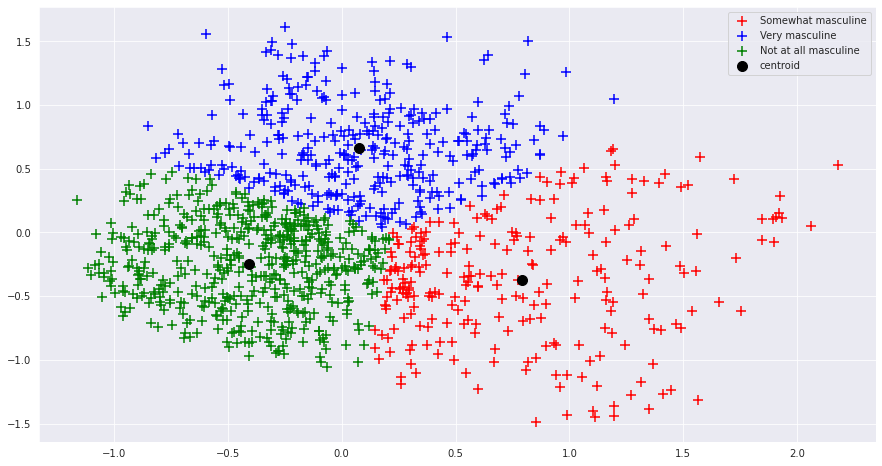

In [16]:
plt.figure(figsize=(15,8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], s = 100, c = 'red', marker='+', label = 'Somewhat masculine')
plt.scatter(X[y == 1, 0], X[y == 1, 1], s = 100, c = 'blue', marker='+', label = 'Very masculine')
plt.scatter(X[y == 2, 0], X[y == 2, 1], s = 100, c = 'green', marker='+', label = 'Not at all masculine')
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1], s = 100, color='black', label='centroid')
plt.legend()
plt.show()